In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import time

# Read in the images (and their file sizes)

In [2]:
filenames = glob('IR_images/*.jpg')
filenames.sort(key=lambda filename: os.stat(filename).st_mtime)
file_sizes = [os.path.getsize(filename) for filename in filenames]

# Iteratively label new images using a crude classifier & incorporate human-assigned labels
Making labeling as painless as possible is crucial. Also making the process repeatable without corrupting any hand-assigned labels, so that it's easy to add and review new training data.

In [3]:
if os.path.isfile('IR_is_open.csv'):
    df = pd.read_csv('IR_is_open.csv', index_col=0)
else:
    df = pd.DataFrame(columns=['file_size', 'is_open_guess', 'is_open_human', 'is_open'])
    
for filename, file_size in zip(filenames, file_sizes):
    df.loc[filename, 'file_size'] = int(file_size)

df.is_open_guess = (df.file_size >= 18000).astype(int)

df.is_open = df.is_open_human
index = df.is_open.isnull()
df.loc[ index, 'is_open'] = df.loc[ index, 'is_open_guess']

df.to_csv('IR_is_open.csv')

# Inspect the distribution of guessed labels

In [4]:
df.groupby('is_open_guess').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open_guess,
0,233
1,106


# Inspect the distribution of labels after incorporating human-assigned labels

In [5]:
df.groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open,
0.0,155
1.0,184


# Read in all images and convert to luminocity images, then to vectors

In [6]:
from PIL import Image

filenames = df.index.values
t1 = time.time()
images = [np.reshape(np.asarray(Image.open(filename).convert('L')), (-1)) for filename in filenames]
t2 = time.time()
print (t2-t1),'(',(t2-t1)/len(filenames),')'

4.56445598602 ( 0.0134644719352 )


# Detemine cut point for training / test split
I split the dataset for training/test as though it was time series data (I figured that adjacent images might be very similar to each other and that randomly selecting train/test might leak the target label).

In [7]:
sample_size = len(filenames)
cut_point = int(sample_size * 0.7)

In [8]:
print "Training set"
df.iloc[0:cut_point].groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

Training set


,count
is_open,
0.0,101
1.0,136


In [9]:
print "Test set"
df.iloc[cut_point:-1].groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

Test set


,count
is_open,
0.0,53
1.0,48


# See if the classes are easily separable using PCA
PCA in low dimensional space has the advantage of being interpretable to a certain extent (e.g. with contour plots in 2d so that we can inspect the generalization of a classifier).

# 2D PCA
The classes are somewhat separable it seems. The cluster on the negative extreme of the x-axis in the chart appears to be overlapping.

6.14139604568 ( 0.0181162125241 )


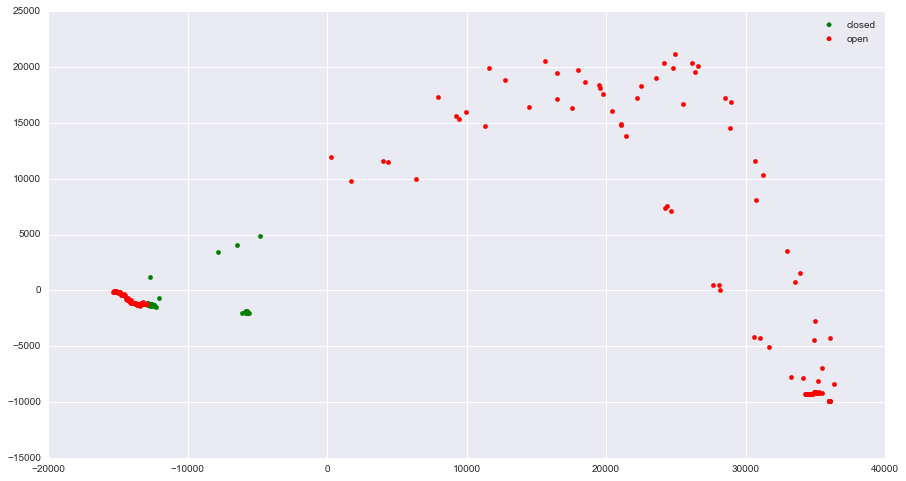

In [10]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=2)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/len(filenames),')'

plt.figure(figsize=(15,8))
vectors_closed = vectors[ (df.is_open == 0).values ]
vectors_open = vectors[ (df.is_open == 1).values ]
plt.scatter(x=vectors_closed[0], y=vectors_closed[1], color='green', label='closed')
plt.scatter(x=vectors_open[0], y=vectors_open[1], color='red', label='open')
plt.legend()
plt.show()

# 3D PCA
Perhaps the classes are easily separable in three dimension? .. No. Not much improvement it seems.

6.40528106689 ( 0.0188946344156 )


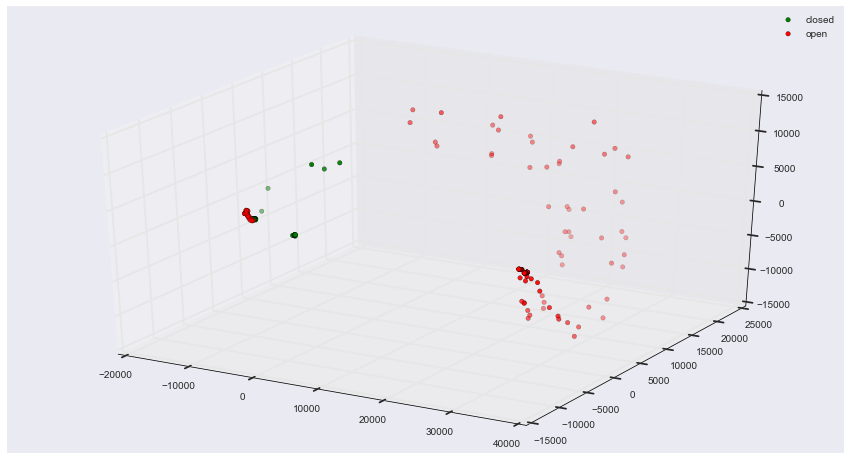

In [11]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=3)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
vectors_closed = vectors[ (df.is_open == 0).values ]
vectors_open = vectors[ (df.is_open == 1).values ]
ax.scatter(vectors_closed[0], vectors_closed[1], vectors_closed[2], c='green', label='closed')
ax.scatter(vectors_open[0], vectors_open[1],  vectors_open[2], c='red', label='open')
ax.legend()
plt.show()

In [12]:
X = vectors
y = df.is_open
X_train = X[0:cut_point]
X_test = X[cut_point:-1]
y_train = y[0:cut_point]
y_test = y[cut_point:-1]

# ROC curves for low dimensions of PCA
Not much better than guesswork it seems.

5.72940397263 ( 0.0169008966744 )


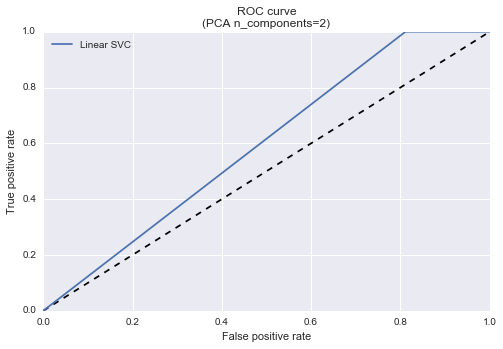

6.02012705803 ( 0.0177584868968 )


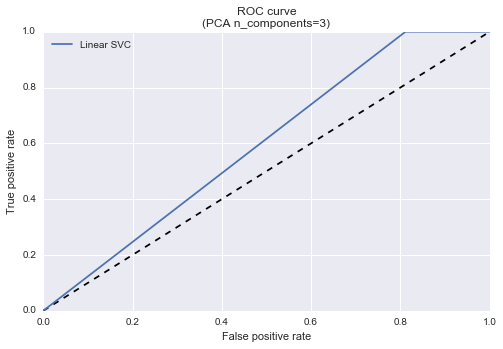

7.37834692001 ( 0.0217650351623 )


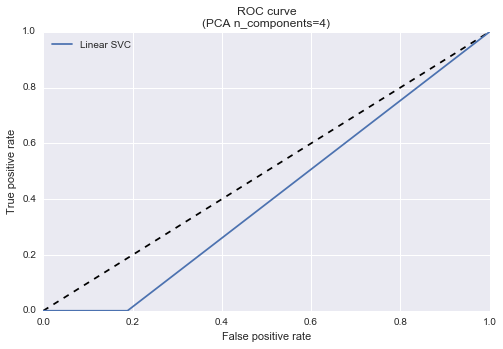

7.8288769722 ( 0.0230940323664 )


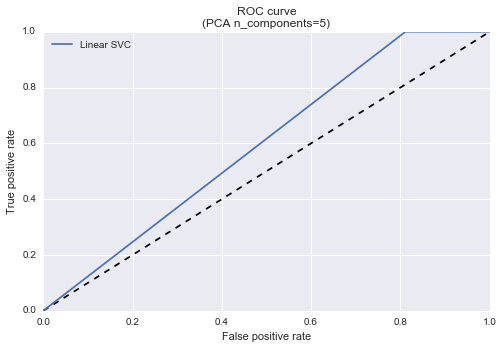

7.29941105843 ( 0.0215321860131 )


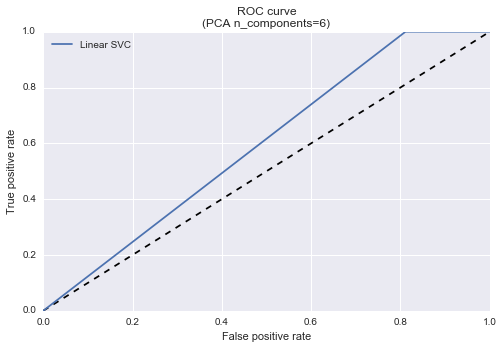

10.2110450268 ( 0.0301210767752 )


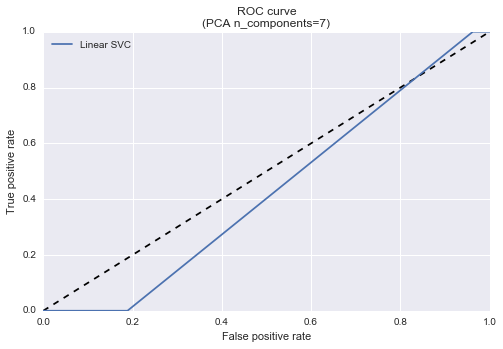

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import svm

for n_components in [2,3,4,5,6,7]:
    from sklearn.decomposition import PCA
    t1 = time.time()
    pca = PCA(n_components=n_components)
    pca.fit(images)
    vectors = pd.DataFrame(pca.transform(images))
    t2 = time.time()
    print (t2-t1),'(',(t2-t1)/sample_size,')'

    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)  
    y_pred_rt = clf.predict_proba(X_test)[:, 1]
    fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

    plt.figure(1, figsize=(8,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label='Linear SVC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve\n(PCA n_components='+str(n_components)+')')
    plt.legend(loc='best')
    plt.show()



# Training on the raw image data

# Setup train/test split

In [14]:
X = images
y = df.is_open
X_train = X[0:cut_point]
X_test = X[cut_point:-1]
y_train = y[0:cut_point]
y_test = y[cut_point:-1]

# Train a logistic regression classifier

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)  

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Look at it's confusion matrix and ROC curve
It's really doing *very* well.

[[53  0]
 [ 0 48]]
[[155   0]
 [  0 184]]


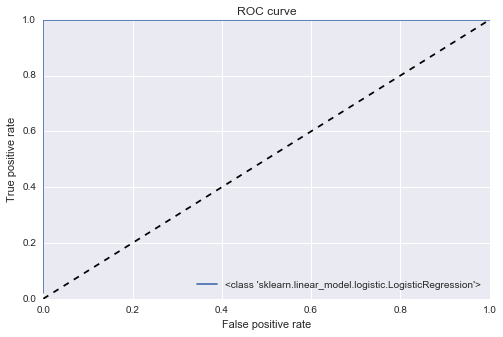

In [16]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
print confusion_matrix(y_test, y_pred)

y_pred = clf.predict(X)
print confusion_matrix(y, y_pred)

y_pred_rt = clf.predict_proba(X_test)[:, 1]
fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

plt.figure(1, figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label=str(type(clf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Inspect the coefficients to ensure it's learned something reasonable

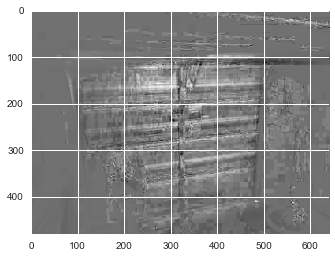

In [17]:
plt.imshow(np.reshape(clf.coef_[0], (480,640)));

# Steps to world domination (err.. rollout):

- Create a github project
- Install Python 2.7 on the raspberrypi and figure out, document, and install all the dependencies
- Persist the classifier (pickle? better way?)
- Create a script to watch for new image files
- Classify new image files & append results to a classification csv (clipped to last N classifications - 1000?)
- Add sms-notification mechanism to the script with incremental back-off (0 minutes, 5, 10, 20, 40, 80, ...)

# Serialize the classifier to JSON

In [52]:
import json

persist = dict()
persist['params'] = clf.get_params()
persist['coef_'] = clf.coef_.tolist()
persist['intercept_'] = clf.intercept_.tolist()
persist['n_iter_'] = clf.n_iter_.tolist()
persist['classes_'] = clf.classes_.tolist()
persist_json = json.dumps(persist)

with open('classifier.json', 'w') as file:
    file.write(persist_json)

# Manually verify serialization

[[53  0]
 [ 0 48]]
[[155   0]
 [  0 184]]


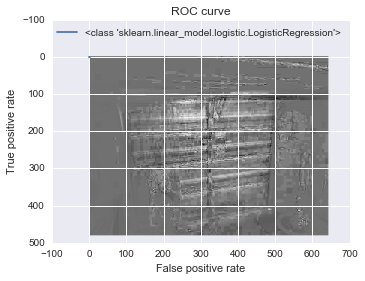

In [50]:
refresh = json.loads(persist_json)
refresh_clf = LogisticRegression()
refresh_clf.set_params(**refresh['params'])
refresh_clf.coef_ = np.asarray(refresh['coef_'])
refresh_clf.intercept_ = np.asarray(refresh['intercept_'])
refresh_clf.n_iter_ = np.asarray(refresh['n_iter_'])
refresh_clf.classes_ = np.asarray(refresh['classes_'])

plt.imshow(np.reshape(refresh_clf.coef_[0], (480,640)));

y_pred = refresh_clf.predict(X_test)
print confusion_matrix(y_test, y_pred)

y_pred = refresh_clf.predict(X)
print confusion_matrix(y, y_pred)

y_pred_rt = refresh_clf.predict_proba(X_test)[:, 1]
fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

plt.figure(1, figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label=str(type(refresh_clf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()